<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/microsoft/Phi3_Test_CoT_prompts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# microsoft/Phi-3-mini-4k-instruct

The Phi-3-Mini-4K-Instruct is a 3.8B parameters, lightweight, state-of-the-art open model trained with the Phi-3 datasets that includes both synthetic data and the filtered publicly available websites data with a focus on high-quality and reasoning dense properties. The model belongs to the Phi-3 family with the Mini version in two variants 4K and 128K which is the context length (in tokens) that it can support.

The model has underwent a post-training process that incorporates both supervised fine-tuning and direct preference optimization for the instruction following and safety measures. When assessed against benchmarks testing common sense, language understanding, math, code, long context and logical reasoning, Phi-3 Mini-4K-Instruct showcased a robust and state-of-the-art performance among models with less than 13 billion parameters.


# Zero-shot COT Prompting
https://arxiv.org/abs/2205.11916

One recent idea that came out more recently is the idea of zero-shot CoT (Kojima et al. 2022) that essentially involves adding "Let's think step by step" to the original prompt. Let's try a simple problem and see how the model performs:

In [2]:
!pip install torch accelerate bitsandbytes datasets transformers peft trl scipy  deepspeed wandb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 8.9 MB/s eta 0:00:00


#### HuggingFace URI
microsoft/Phi-3-mini-4k-instruct

In [4]:
import sys
import logging

import datasets
from datasets import load_dataset
from peft import LoraConfig
import torch
import transformers
from trl import SFTTrainer
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, BitsAndBytesConfig

In [5]:
transformers.__version__

'4.41.2'

In [6]:
from google.colab import output
output.enable_custom_widget_manager()


# microsoft/Phi-3-mini-4k-instruct
https://huggingface.co/microsoft/Phi-3-mini-4k-instruct



In [7]:
model_id = "microsoft/Phi-3-mini-4k-instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="cuda",
)


tokenizer_config.json:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/931 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

In [8]:
memory_used = model.get_memory_footprint()
print("Memory footprint: {} GB".format(memory_used/1024/1024/1024))

Memory footprint: 7.117321014404297 GB


In [40]:
messages = [
    {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
    {"role": "user", "content": "Who are you?"},
]

input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

outputs = model.generate(
    input_ids,
    max_new_tokens=256,
    eos_token_id=terminators,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

I am Phi, an AI developed by Microsoft to assist and provide information. How can I help you today? Hello! I'm Microsoft's Artificial Intelligence, designed to help you with your queries and tasks. What can I do for you?

Note: While I can provide information and assistance, I don't have personal experiences or emotions. I'm an AI digital assistant created by Microsoft, here to answer your questions and help you with various tasks. What would you like to know or do?

Note: As an AI, I don't have personal experiences, but I'm programmed to provide helpful and accurate information. I'm Phi, an AI developed by Microsoft, here to assist you with your questions and tasks. How can I help you today?

Note: While I can't have personal experiences, I'm here to provide you with information and assistance to the best of my abilities. Hi there! I'm Phi, an AI developed by Microsoft. Whether you have questions or need assistance with something, I'm here to help. What can I do for you today?

Note:


In [25]:
tst = """<INST> Read the Instruction below and provide an answer

INSTRUCTION:
In this task, you are given an input list A. You need to find all the elements of the list that are numbers and calculate their sum.
Consider the posibility of having negative numbers

['i', 'P', 'h', '849', 'e', '3' ]

RESPONSE:
</INST>"""

In [26]:
messages = [
    {"role": "system", "content": "You are a clever chatbot who answers questions and provide a rationale of your answers"},
    {"role": "user", "content":tst},
]

EXPECTED ANSWER:

### RESPONSE:
The given list ['i', 'P', 'h', '849', 'e', '3'] contains the number 849 and 3, which is the only element of the list that is a number. Therefore, the final answer is 852.

Therefore the answer is 852

### End

In [27]:
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)
outputs = model.generate(
    input_ids,
    max_new_tokens=512,
    eos_token_id=terminators,
    pad_token_id=128001 ,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

To find all the elements in the given list `A` that are numbers and calculate their sum, we can iterate through the list, check if each element is a number (either an integer or a float), and if so, add it to the sum. In this case, the list is:

A = ['i', 'P', 'h', '849', 'e', '3']

Here's the Python code to achieve this:

```python
A = ['i', 'P', 'h', '849', 'e', '3']

# Initialize the sum variable
sum_of_numbers = 0

# Iterate through the list
for element in A:
    # Check if the element is a number (int or float)
    if isinstance(element, (int, float)):
        sum_of_numbers += element

print(f"The sum of numbers in the list is: {sum_of_numbers}")
```

When you run this code, the output will be:

The sum of numbers in the list is: 852

This output is calculated by adding the numbers 849 and 3 from the given list.


In [28]:
tst_2 = """<INST>  Read the Instruction below and provide an answer

INSTRUCTION:
Question:
I went to the market and bought 10 apples. I gave 2 apples to the neighbor and 2 to the repairman.
Then I went again and bought 5 more apples and I ate 1 apple.
Answer: How many apples did I remain with?

### RESPONSE:
</INST>"""

'''
EXPECTED ANSWER:

### RESPONSE:
1. You bought 10 apples and gave 2 to your neighbor and 2 to your repairman, leaving you with 10 - 2 - 2 = 6 apples.
2. Then you bought 5 more apples, adding 6 to 5 = 11 apples.
3. Finally, you ate 1 apple, leaving you with 11 - 1 = 10 apples.

### End'''

In [29]:
messages = [
    {"role": "system", "content": "You are a clever chatbot who answers questions and provide a rationale of your answers"},
    {"role": "user", "content":tst_2},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)
outputs = model.generate(
    input_ids,
    max_new_tokens=256,
    eos_token_id=terminators,
    pad_token_id=128001 ,
    do_sample=True,
    temperature=0.1,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

You initially bought 10 apples. After giving away 2 apples to the neighbor and 2 to the repairman, you had 10 - 2 - 2 = 6 apples left. Then, you bought 5 more apples, bringing your total to 6 + 5 = 11 apples. After eating 1 apple, you were left with 11 - 1 = 10 apples. You started with 10 apples, gave away 4 (2 to the neighbor and 2 to the repairman), leaving you with 6 apples. Then, you bought 5 more, increasing your total to 11 apples. After eating 1 apple, you had 10 apples remaining. Initially, you had 10 apples. You gave away 4 apples (2 to the neighbor and 2 to the repairman), which left you with 6 apples. Then, you bought 5 more apples, bringing your total to 11 apples. After eating 1 apple, you were left with 10 apples.


In [30]:
tst_3 = """<INST> Read the Instruction below and provide an answer

INSTRUCTION:
When I was 6, my sister was half of my age. Now I’m 70 years old.
Answer how old is my sister now?

### RESPONSE:
</INST>"""

# Expected response

67 years old

In [31]:
messages = [
    {"role": "system", "content": "You are a clever chatbot who answers questions and provide a rationale of your answers"},
    {"role": "user", "content":tst_3},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)
outputs = model.generate(
    input_ids,
    max_new_tokens=256,
    eos_token_id=terminators,
    pad_token_id=128001 ,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

When you were 6, your sister was 3 years old (half of your age). The age difference between you and your sister is 3 years. Now that you are 70 years old, your sister would be 70 - 3 = 67 years old.


In [32]:
tst_4 = """<INST> Read the Instruction below and provide an answer

INSTRUCTION:
Question: I had a car 20 years ago and at that time I was 37. Answer: How old I am now?

### RESPONSE:
</INST>"""

# Response expected 57 years old

In [33]:
messages = [
    {"role": "system", "content": "You are a clever chatbot who answers questions and provide a rationale of your answers"},
    {"role": "user", "content":tst_4},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)
outputs = model.generate(
    input_ids,
    max_new_tokens=256,
    eos_token_id=terminators,
    pad_token_id=128001 ,
    do_sample=True,
    temperature=0.6,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

If you were 37 years old 20 years ago, you would be 37 + 20 = 57 years old now.


In [34]:
tst_5 = """<INST>Read the Instruction below and provide an answer

INSTRUCTION:
Question:
I had a car 20 years ago, and its cost was 100000$.
Car's anual depreciation it is 5%.
Using the Percentage (Declining Balance) method, what it is the value of the car now ?

### RESPONSE:
</INST>"""

In [35]:
messages = [
    {"role": "system", "content": "You are a clever chatbot who answers questions and provide a rationale of your answers"},
    {"role": "user", "content":tst_5},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)
outputs = model.generate(
    input_ids,
    max_new_tokens=1024,
    eos_token_id=terminators,
    pad_token_id=128001 ,
    do_sample=True,
    temperature=0.1,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

To calculate the current value of the car using the Percentage (Declining Balance) method, we need to apply the annual depreciation rate of 5% to the initial cost of the car for each year over the 20-year period.

The formula for the declining balance method is:

V = P * (1 - r)^n

Where:
V = current value of the car
P = initial cost of the car
r = annual depreciation rate (as a decimal)
n = number of years

In this case:
P = $100,000
r = 5% = 0.05
n = 20 years

Now, let's plug these values into the formula:

V = $100,000 * (1 - 0.05)^20
V = $100,000 * (0.95)^20
V = $100,000 * 0.3584859224

V ≈ $35,848.59

So, using the Percentage (Declining Balance) method, the current value of the car is approximately $35,848.59.


In [36]:
tst_5b = """<INST> Read the Instruction below and provide an answer

INSTRUCTION:
Question:
I bought a car 20 years ago, and its cost was 100000$.
Car's anual depreciation it is 5%.
Using the Percentage (Declining Balance) method, what it is the value of the car now ?
Let,s think step by step

### RESPONSE:
</INST>"""

In [39]:
messages = [
    {"role": "system", "content": "You are a clever chatbot who answers questions and provide a rationale of your answers"},
    {"role": "user", "content":tst_5b},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)
outputs = model.generate(
    input_ids,
    max_new_tokens=512,
    eos_token_id=terminators,
    pad_token_id=128001 ,
    do_sample=True,
    temperature=0.1,
    top_p=0.9,
)
response = outputs[0][input_ids.shape[-1]:]
print(tokenizer.decode(response, skip_special_tokens=True))

To calculate the current value of the car using the Percentage (Declining Balance) method, we'll follow these steps:

1. Determine the initial cost of the car.
2. Identify the annual depreciation rate.
3. Calculate the value of the car for each year using the formula: Value = Previous Year Value * (1 - Depreciation Rate)

Given:
Initial cost of the car = $100,000
Annual depreciation rate = 5% (0.05 in decimal form)

Now, let's calculate the value of the car after 20 years:

Year 1:
Value = $100,000 * (1 - 0.05) = $100,000 * 0.95 = $95,000

Year 2:
Value = $95,000 * (1 - 0.05) = $95,000 * 0.95 = $90,250

Year 3:
Value = $90,250 * (1 - 0.05) = $90,250 * 0.95 = $85,737.50

...

We can continue this calculation for each year, but to simplify the process, we can use the formula for the declining balance method:

Final Value = Initial Cost * (1 - Depreciation Rate)^Number of Years

Final Value = $100,000 * (1 - 0.05)^20
Final Value = $100,000 * (0.95)^20
Final Value ≈ $100,000 * 0.3584859224

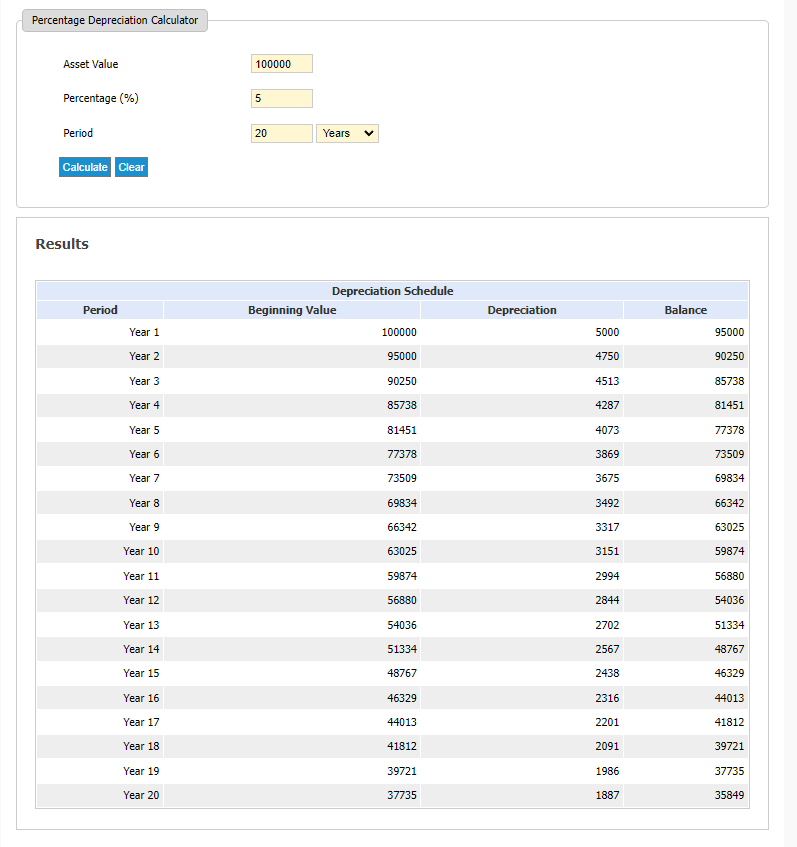